In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/LEVEL 1/torch')
from multiclass_functions1 import * # my module import
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Mounted at /content/drive
cpu


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.1 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
BATCH_SIZE = 32
LR = 1e-3
EPOCH = 5
criterion = nn.CrossEntropyLoss()
new_model_train = False
model_type = "CNN_deep"
dataset = "CIFAR10"
save_model_path = f"/content/drive/MyDrive/Colab Notebooks/results/{model_type}_{dataset}_aug.pt"

In [ ]:
def square(x):
    return x**2

In [ ]:
transform_train = transforms.Compose([
    # transforms.Resize(size=(20, 20)), # size는 (height,width)
    # transforms.CenterCrop(size=(20,20)), # size 는 (height, width)
    # transforms.RandomCrop(size=(20,20)), # 어디를 자를지 random 하게 자름
    # transforms.Pad(6), # 20+6*2 = 32
    # transforms.RandomApply(nn.ModuleList([transforms.CenterCrop(size=(20,20)),
    #                                       transforms.Pad(6)]), p=0.5), # ModuleList 안해도 되더라
    # transforms.RandomResizedCrop(scale=(0.3,1), ratio=(0.3,1.7), size=(32,32)),
    # # random 하게 자른 다음에 resize라서 RandomCrop과 다름
    # # scale은 어느 정도로 작은 범위를 자를지 (0~1 사이 값)
    # # ratio는 aspect ratio로, 가로 길이/세로 길이 를 의미한다.
    # # (a,b) <- a 와 b 사이 값을 uniform random 하게 뽑아요

    # transforms.RandomGrayscale(p=0.5), # gray로 바꾸는 데, 출력 채널 수를 3으로 유지
    # transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.5, hue=0.15),
    # # 밝기, 대비, 채도, 색조가 센서마다 다를 수 있음을 고려 (number: percentage to convert)
    # # 밝기(brightness)를 키우면 밝은 부분에서 saturation이 일어나면서, Dynamic Range가 낮은 센서에 대응 가능
    # # 대비(contrast) augmentation은 HDR이 서로 다른 센서에 대응 가능
    # # 채도(saturation) 및 색조(hue) augmentation은 ISP에서 color correction matrix 값이 센서마다 서로 다른 경우 등,
    # # 색 표현이 다른 센서에 대응 가능
    # transforms.RandomAutocontrast(p=0.5), # p의 확률로 대비를 자동 조정
    # transforms.RandomEqualize(p=0.5), # p의 확률로 R,G,B histogram을 일치시킴 (이건 uint8로 되어있는 이미지만 가능)
    # transforms.RandomInvert(p=0.5), # p의 확률로 색반전
    # # new 픽셀 값 = 최댓 값 - 기존의 픽셀 값 을 통해 반전시킴
    # transforms.RandomSolarize(threshold=200, p=0.5),
    # # p의 확률로(즉 그 이미지에 대해 할지 말지 정하고) threshold 넘는 픽셀 값에 대해 inverting
    # transforms.RandomPosterize(bits=3, p=0.5),
    # # 픽셀 하나가 가지는 값의 bit수(0~8)를 p의 확률로 bits로 바꿈 (이건 uint8로 되어있는 것만 가능)

    # transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1,2)),
    # # kernel_size = (가로,세로) sigma=(min,max) min ~ max 에서 uniform 하게 하나 뽑음
    # transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    # # sharpness_factor = 1 이면 원래 이미지, 0에 가까우면 blur, 1보다 클수록 sharp해짐

    # transforms.RandomHorizontalFlip(p=0.4), # p 확률로 좌우반전
    # transforms.RandomVerticalFlip(p=0.5), # p 확률로 상하반전
    # transforms.RandomRotation(degrees=(0,180)), # 0~180도 랜덤하게 회전
    # transforms.RandomAffine(degrees=(0,30),translate=(0.1,0.3),scale=(0.5,1.2)),
    # # translate는 이동하는 정도 (비율), scale은 크기 조절
    # transforms.RandomPerspective(distortion_scale=0.6, p=0.5), # distortion 정도 0~1 사이, default는 0.5, p는 적용 확률

    # transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    # transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    # transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN),
    # # AutoAugment:Learning Augmentation Strategies from Data 라는 논문에 따른 augmentation (uint8 이여야 함)
    # transforms.RandAugment(),
    # # RandAugment: Practical automated data augmentation with a reduced search space 라는 논문에 따른 augmentation (uint8 이여야 함)
    # transforms.TrivialAugmentWide(),
    # # TrivialAugment: Tuning-free Yet State-of-the-Art Data Augmentation 라는 논문에 따른 augmentation (uint8)
    # transforms.AugMix(),
    # # AugMix: A Simple Data Processing Method to Improve Robustness and Uncertainty 라는 논문에 따른 augmentaiton (uint8)

    transforms.ToTensor(), # 얘는 항상 살려줘야함

    # transforms.RandomErasing(p=0.5, scale=(0.03,0.3), ratio=(0.3,3.3)), # ToTensor 뒤에 와야
    # # scale: 이미지의 몇 퍼 정도를 지울지
    # # ratio: 지우는 영역의 aspect ratio

    # transforms.Lambda(square),
    # square, # 가능
    # transforms.Lambda(lambda x:x**2),
    # lambda x:x**2, # 가능

    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    # # (아마도) 이미지넷 데이터 전체 픽셀에 대해서 구한 평균, std 값
    ])

transform_test = transforms.ToTensor()

train_DS = datasets.CIFAR10(root = '/content/drive/MyDrive/Colab Notebooks/data', train=True, download=True, transform=transform_train)
test_DS = datasets.CIFAR10(root = '/content/drive/MyDrive/Colab Notebooks/data', train=False, download=True, transform=transform_test)
train_DL = torch.utils.data.DataLoader(train_DS, batch_size = BATCH_SIZE, shuffle = True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size = BATCH_SIZE, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


image size = torch.Size([3, 32, 32])
image size = torch.Size([3, 32, 32])


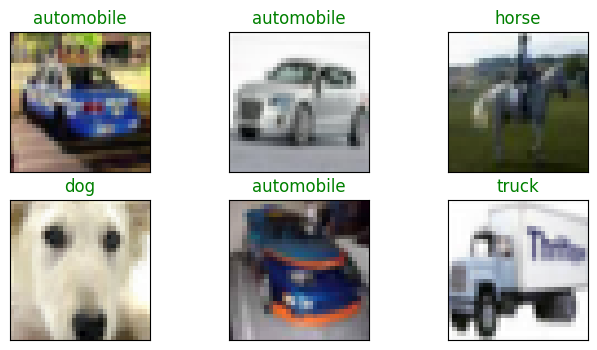

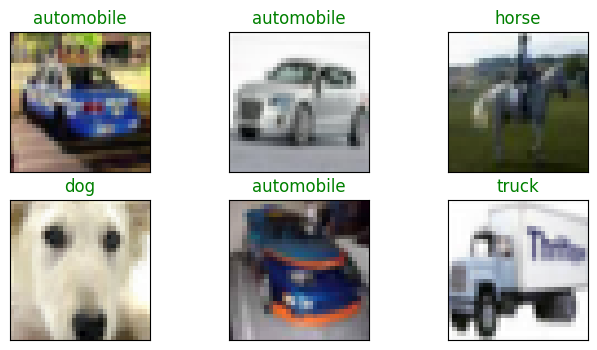

In [ ]:
from PIL import Image
def im_plot(x_numpy, y_batch, transform):
    plt.figure(figsize=(8,4))
    for idx in range(6):
        im = Image.fromarray(x_numpy[idx])
        im = transform(im)
        im = im-im.min() # for imshow clipping
        im = im/im.max() # for imshow clipping

        plt.subplot(2,3, idx+1, xticks=[], yticks=[])
        plt.imshow(im.permute(1,2,0))
        true_class = test_DS.classes[y_batch[idx]]
        plt.title(true_class, color = "g")
    print(f"image size = {im.shape}")

idx = torch.randint(0,10000,(6,))
x_batch = test_DS.data[idx]
targets = torch.tensor(test_DS.targets) # 리스트라서 텐서로 바꿔줌 (random idx로 인덱싱 하기위해)
y_batch = targets[idx]
im_plot(x_batch, y_batch, transform_test)
im_plot(x_batch, y_batch, transform_train)

In [ ]:
# # Albumentation 쓸 때만 주석 해제

# transform_train = A.Compose([
#     # A.Resize(32,32),
#     # A.HorizontalFlip(p=0.5),
#     # A.VerticalFlip(p=0.5),

#     # A.ShiftScaleRotate(shift_limit=(-0.05,0.05), scale_limit=(-0.05,0.05), rotate_limit=(-10,10), p=0.7, border_mode=cv2.BORDER_CONSTANT),
#     # A.RandomResizedCrop(height=32, width=32, scale=(0.9, 1), ratio=(0.75, 1.33), p=0.7),

#     # A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.8),

#     A.OneOf([
#              A.ElasticTransform(p=1, sigma=2, alpha=10, alpha_affine=1),
#              # sigma는 간격, alpha는 꼬불한 정도, alpla_affine은 affine transform의 정도
#              A.GridDistortion(p=1), # grid로 쪼갠다음 각 patch들을 짜부시킴
#              A.OpticalDistortion(p=1, distort_limit=1, shift_limit=0.5),
#              # distort_limit 가운데 부분이 볼록 튀어나와 보이는 정도 (0~1), shift_limit은 어느정도 이미지를 밀건지 (0~1)
#              ], p=1),

#     A.Normalize(), # 애는 default가 0~255인 이미지가 들어오는 것으로 되어있어서 normalize 먼저! 참고: https://github.com/albumentations-team/albumentations/blob/main/albumentations/augmentations/transforms.py#L155
#     ToTensorV2()])

# transform_test = A.Compose([A.Normalize(),
#                             ToTensorV2()]) # type, 값의 범위는 그대로, Tensor, 개채행열로만 바꿔줌

# class CIFAR10_custom(datasets.CIFAR10):
#     def __init__(self, root="/content/drive/MyDrive/Colab Notebooks/data", train=True, download=True, transform=None):
#         super().__init__(root=root, train=train, download=download, transform=transform)

#     def __getitem__(self, index):
#         image = self.data[index]
#         label = self.targets[index]

#         if self.transform is not None:
#             transformed = self.transform(image=image)
#             image = transformed["image"]

#             # transformed = self.transform(image=image, bboxes=bboxes, category_ids=category_ids) # for object detection

#             # transformed = self.transform(image=image, mask=mask) # for segmentation
#             # image = transformed["image"] # for segmentation
#             # mask = transformed["mask"] # for segmentation

#         return image, label

# train_DS = CIFAR10_custom(root = '/content/drive/MyDrive/Colab Notebooks/data', train=True, download=True, transform=transform_train)
# test_DS = CIFAR10_custom(root = '/content/drive/MyDrive/Colab Notebooks/data', train=False, download=True, transform=transform_test)
# train_DL = torch.utils.data.DataLoader(train_DS, batch_size = BATCH_SIZE, shuffle = True)
# test_DL = torch.utils.data.DataLoader(test_DS, batch_size = BATCH_SIZE, shuffle = True)

<ipython-input-61-3aafb180e015>:14: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(p=1, sigma=2, alpha=10, alpha_affine=1),


Files already downloaded and verified
Files already downloaded and verified


image size = torch.Size([3, 32, 32])
image size = torch.Size([3, 32, 32])


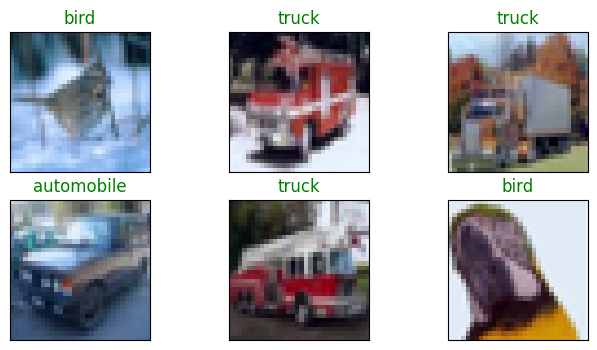

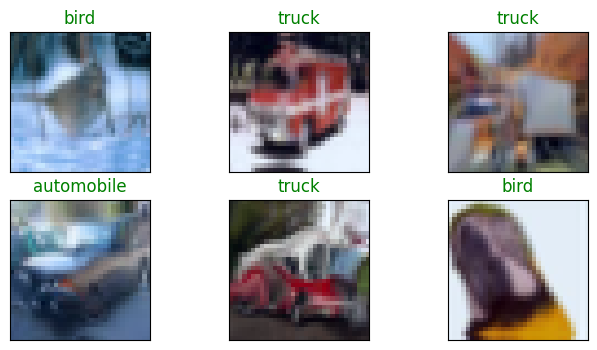

In [ ]:
# # Albumentation 쓸 때만 주석 해제
# def im_plot(x_numpy, y_batch, transform):
#     plt.figure(figsize=(8,4))
#     for idx in range(6):
#         # print(x_numpy.shape)
#         transformed = transform(image=x_numpy[idx])
#         im = transformed["image"]
#         im = im-im.min() # for imshow clipping
#         im = im/im.max() # for imshow clipping

#         plt.subplot(2,3, idx+1, xticks=[], yticks=[])
#         plt.imshow(im.permute(1,2,0))
#         true_class = test_DS.classes[y_batch[idx]]
#         plt.title(true_class, color = "g")
#     print(f"image size = {im.shape}")

# idx = torch.randint(0,10000,(6,))
# x_batch = test_DS.data[idx]
# targets = torch.tensor(test_DS.targets) # 리스트라서 텐서로 바꿔줌 (random idx로 인덱싱 하기위해)
# y_batch = targets[idx]
# im_plot(x_batch, y_batch, transform_test)
# im_plot(x_batch, y_batch, transform_train)

In [ ]:
class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(3,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.Conv2d(32,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)

        self.conv_block2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(nn.Conv2d(64,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)

        self.classifier = nn.Sequential(nn.Linear(128*4*4,512),
                                        nn.ReLU(),
                                        nn.Linear(512,10))

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

In [ ]:
model = globals()[model_type]().to(DEVICE)
print(model)
x_batch, _ = next(iter(train_DL))
print(x_batch.shape)
print(model(x_batch.to(DEVICE)).shape)

# print(count_params(model))

CNN_deep(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=

In [ ]:
if new_model_train:
    optimizer = optim.Adam(model.parameters(), lr = LR)

    loss_history = Train(model, train_DL, criterion, optimizer, EPOCH)

    torch.save(model, save_model_path)

    plt.figure()
    plt.plot(range(1,EPOCH+1),loss_history)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train Loss")
    plt.grid()

In [ ]:
load_model = torch.load(save_model_path, map_location=DEVICE)

In [ ]:
Test(load_model, test_DL)
print(count_params(load_model))

Test accuracy: 7966/10000 (79.7 %)
1527018


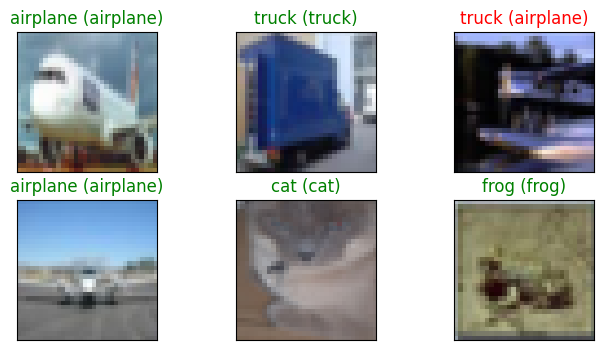

In [ ]:
Test_plot(load_model,test_DL)

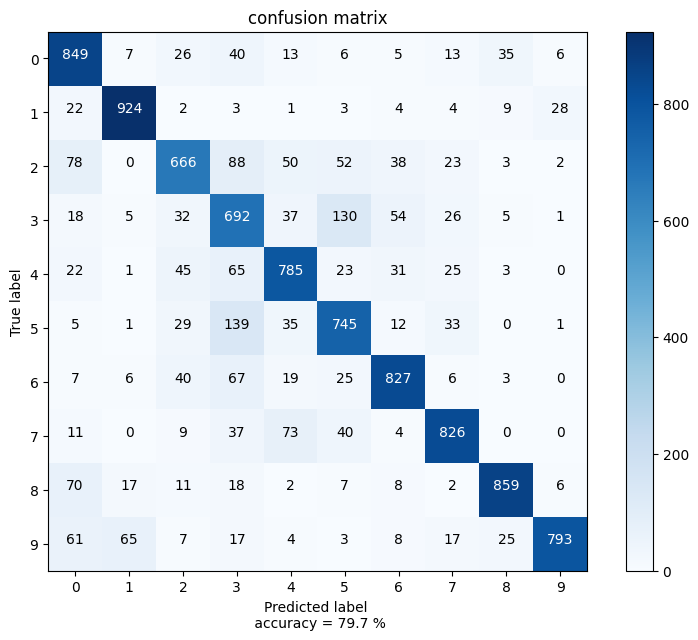

In [ ]:
confusion = get_conf(load_model, test_DL)
plot_confusion_matrix(confusion)